# FIT5202 : Music Recommendation using Collaborative Filtering

Collaborative filtering (CF) is a technique commonly used to build personalized recommendations on the Web. Some popular websites that make use of the collaborative filtering technology include Amazon, Netflix, iTunes, IMDB, LastFM, Delicious and StumbleUpon. In collaborative filtering, algorithms are used to make automatic predictions about a user's interests by compiling preferences from several users.

In this lab, our task is to use a collaborative algorithm to recommend top artists from the given dataset. The dataset can be downloaded from Moodle. 
<p style="color:red">Complete the required tasks in the tutorial. The activites are denoted as "Task" with the required instructions.</p>
<br/>

## Table of Contents

* [ALS Lecture Demo](#als-demo)
* [Use-Case Music Recommendation](#use-case)
    * [Data Loading](#data-loading)
    * [Data Preparation](#data-prep)
    * [Data Exploration](#data-exploration)
    * [Train-Test Split](#train-test-split)
    * [Model Building](#model-building)
    * [Evaluation](#evaluation)
    * [Hyperparameter Tuning and Cross Validation](#cv)
    * [Making Predictions](#predictions)    
* [Lab Tasks](#lab-task-1)
    * [Lab Task 1](#lab-task-1)
    * [Lab Task 2](#lab-task-2)
    * [Lab Task 3](#lab-task-3)
    * [Lab Task 4](#lab-task-4)
    * [Lab Task 5](#lab-task-5)
    * [Lab Task 6](#lab-task-6)
    
## Including Libraries and Initializing Spark Context

In [2]:
#import libraries
from pyspark import SparkContext
from pyspark.ml.recommendation import ALS
from pyspark.sql import SparkSession ,Row
from pyspark.sql.functions import col,split
from pyspark.sql.types import StructType,StructField,IntegerType,StringType


appName="Collaborative Filtering with PySpark"
#initialize the spark session
spark = SparkSession.builder.appName(appName).getOrCreate()
#get sparkcontext from the sparksession
sc = spark.sparkContext

## Alternating Least Squares DEMO <a class="anchor" name="als-demo"></a>

Please go through the ALS Demo presented in the Lecture to understand the basic flow before starting with the lab tasks.

## Use-Case : Music Recommendation <a class="anchor" name="use-case"></a>
The goal here is to use the data provided to create a recommendation system using collaborative filtering using the social influence data and predict artists a user might like but have not listened to.

> Consider the following example. If user A is a neighbor of user B, and they have similar musical tastes, then there is a very strong tie between them. If user B is a big fan of artist C, and has scrobbled them numerous times, then there is also a strong tie between them. Based on last.fm’s data, user A has not yet listened to artist C (no link has formed between them yet), and there is a good chance that user A will also like artist C.<a href="https://blogs.cornell.edu/info2040/2012/09/20/last-fm-music-reccomendation-incorporating-social-network-ties-and-collaborative-filtering/#:~:text=their%20listening%20frequency.-,Last.,in%20the%20user's%20local%20network." target="_BLANK">Ref</a>


The original dataset is available at <a href="https://www.last.fm/api/" target="_blank">last.fm api</a>. The dataset provided here is a lighter version, resized for the sake of simplicity. The dataset contains three files as follows:
<ul>
    <li><strong>user_artist_data.txt</strong>
        3 columns: <code>user_id, artist_id, playcount</code></li>
    <li><strong>artist_data.txt</strong>
        2 columns: <code>artist_id ,artist_name</code></li>
    <li><strong>artist_alias.txt</strong>
        2 columns: <code>bad_id, good_id</code>
        [known incorrectly spelt artists and the correct artist id].</li>
</ul>

<a class="anchor" id="lab-task-1"></a>
<div style="background:rgba(0,109,174,0.2);padding:10px;border-radius:4px"><strong style="color:#FF5555">1. Lab Task: </strong> 
Import the two other files (user_artist_data.txt and artist_alias.txt) to create two dataframes <code>df_artist_alias</code> and <code>df_user_artist</code>
    
<strong style="color:red">NOTE:</strong> Check the <strong>delimiter</strong> used in these files. <code>\t</code> may not be used for all files.
</div>.




## Data Loading <a class="anchor" name="data-loading"></a>

In [28]:
import os
os.getcwd()

'/home/student'

In [29]:
root_path = "Labs/Week08/data"

In [30]:
df = spark.read.text(os.path.join(root_path,"artist_data.txt"))
split_col = split(df['value'], '\t')
df = df.withColumn('artist_id', split_col.getItem(0))
df = df.withColumn('artist_name', split_col.getItem(1))
df_artist=df.drop('value')

In [31]:
df_artist.show(1)

+---------+------------+
|artist_id| artist_name|
+---------+------------+
|  1240105|André Visior|
+---------+------------+
only showing top 1 row



In [32]:
#Load user_artist_data.txt to a dataframe called df_user_artist
df = spark.read.text(os.path.join(root_path,"user_artist_data.txt"))
split_col = split(df['value'], ' ')
df = df.withColumn('user_id', split_col.getItem(0))
df = df.withColumn('artist_id', split_col.getItem(1))
df = df.withColumn('play_count', split_col.getItem(2))
df_user_artist=df.drop('value')

In [33]:
#Load artist_alias.txt to a dataframe called df_artist_alias
df = spark.read.text(os.path.join(root_path,"artist_alias.txt"))
split_col = split(df['value'], '\t')
df = df.withColumn('bad_id', split_col.getItem(0))
df = df.withColumn('good_id', split_col.getItem(1))
df_artist_alias=df.drop('value')

## Data Preparation <a class="anchor" name="data-prep"></a>

The <code>df_user_artist</code> contains <strong>bad ids</strong>, so the <strong>bad ids</strong> in the <code>user_artist_data.txt</code> file need to be remapped to <strong>goodids</strong>. The mapping of <strong>bad_ids</strong> to <strong>good_ids</strong> is in <strong>artist_alias.txt</strong> file. The first task is to create a dictionary of the artist_alias, so that it can be passed over a <strong>broadcast variable</strong>.

Broadcast makes Spark send and hold in memory just one copy for each executor in the cluster. When there are thousands of tasks, and many execute in parallel on each executor, this can save significant network traffic and memory.
But you cannot directly broadcast a dataframe, it has to be converted to a list first

In [34]:
from pyspark.sql.functions import col, broadcast

In [35]:
#After loading the artist_alias data to the dataframe, it is converted to a dictionary to be set as a broadcast variable
artist_alias = dict(df_artist_alias.collect())

<a class="anchor" id="lab-task-2"></a>
<div style="background:rgba(0,109,174,0.2);padding:10px;border-radius:4px"><strong style="color:#FF5555">2. Lab Task: </strong> 
For the dictionary <strong>artist_alias</strong> which contains key value pair of badid and goodid, create a broadcast variable called <strong>bArtistAlias</strong>.
</div>

In [36]:
#Write the code below to create a broadcast variable bArtistAlias
# Hints: apply sc.broadcast on artist_alias
bArtistAlias = sc.broadcast(artist_alias)

After the broadcast variable is created, a function to replace the badids by looking up the values from the broadcasted dictionary is implemented.


In [37]:
from pyspark.sql.functions import udf, struct
def lookup_correct_id(artist_id):    
    finalArtistID = bArtistAlias.value.get(artist_id)
    if finalArtistID is None:
        finalArtistID = artist_id
    return finalArtistID    

lookup_udf = udf(lookup_correct_id, StringType())

<a class="anchor" id="lab-task-3"></a>
<div style="background:rgba(0,109,174,0.2);padding:10px;border-radius:4px"><strong style="color:#FF5555">3. Lab Task: </strong> 
    Apply the udf <code>lookup_udf</code> on the column of 'artist_id' to replace the "badids" in the <code>df_user_artist</code> dataframe.
</div>

In [38]:
#Write your code below
df_user_artist = df_user_artist.withColumn('artist_id', lookup_udf('artist_id'))

When we want to repeteadly access a dataframe or an RDD, it is a good idea to cache them, it helps to speed up applications.

In [39]:
#Uncomment this to use caching
df_user_artist.cache()

DataFrame[user_id: string, artist_id: string, play_count: string]

## Data Exploration <a class="anchor" name="data-exploration"></a>

<div style="background:rgba(0,109,174,0.2);padding:10px;border-radius:4px">
    The function below returns top <strong>N</strong> artist for a user with user_id : <code>2062243</code> by joining <code>user</code> and <code>user_artist</code> datasets on the common key <code>artist_id</code>.
</div>



In [43]:
def top_n_artists(artist,user_artist,user_id,limit):
    '''Returns top n artists liked by a particular user'''
    '''Takes artist,user_artist, user_id and limit as input'''
    
    df = artist.join(user_artist,artist.artist_id==user_artist.artist_id)\
            .filter(user_artist.user_id==user_id)\
            .sort(user_artist.play_count.desc())\
            .select(user_artist.user_id,user_artist.play_count,artist.artist_name)\
            .limit(limit)
    return df  

top_n_artists(df_artist,df_user_artist,2062243,60).show(truncate=False)

+-------+----------+----------------------------+
|user_id|play_count|artist_name                 |
+-------+----------+----------------------------+
|2062243|99        |morgan heritage             |
|2062243|98        |Music 205olf                |
|2062243|98        |Mountain                    |
|2062243|98        |The Moody Blues             |
|2062243|98        |Mr C The Slide Man          |
|2062243|98        |La Bouche                   |
|2062243|98        |Moxy Früvous                |
|2062243|98        |Music 205n                  |
|2062243|98        |Music 205tills, Nash & Young|
|2062243|98        |Music 205nders              |
|2062243|98        |Music 205lub                |
|2062243|98        |Music 205its                |
|2062243|98        |Music 205Satins             |
|2062243|98        |Moguai                      |
|2062243|98        |Mousse T.                   |
|2062243|98        |Mortal Combat Soundtrack    |
|2062243|98        |Money Mark                  |


Here we want to convert data types to integer type where required.

In [45]:
#Cast the data column into integer types
for col_name in df_user_artist.columns:
    df_user_artist = df_user_artist.withColumn(col_name, df_user_artist[col_name].cast(IntegerType()))

df_artist = df_artist.withColumn('artist_id', df_artist['artist_id'].cast(IntegerType()))

In [46]:
df_user_artist.printSchema()

root
 |-- user_id: integer (nullable = true)
 |-- artist_id: integer (nullable = true)
 |-- play_count: integer (nullable = true)



In [47]:
df_artist.printSchema()

root
 |-- artist_id: integer (nullable = true)
 |-- artist_name: string (nullable = true)



## Train Test Split <a class="anchor" name="train-test-split"></a>

<a class="anchor" id="lab-task-4"></a>
<div style="background:rgba(0,109,174,0.2);padding:10px;border-radius:4px"><strong style="color:#FF5555">4. Lab Task: </strong> 
Create a deterministic 80/20 split of training and testing dataset.
</div>

In [49]:
from pyspark.sql.functions import split

train, test = df_user_artist.randomSplit([0.8, 0.2], 31479391)

## Model Building <a href="https://spark.apache.org/docs/latest/ml-collaborative-filtering.html" target="_blank">[REF]</a> <a class="anchor" name="model-building"></a>
Collaborative filtering is commonly used for recommender systems. These techniques aim to fill in the missing entries of a user-item association matrix. spark.ml currently supports model-based collaborative filtering, in which users and products are described by a small set of latent factors that can be used to predict missing entries. spark.ml uses the alternating least squares (ALS) algorithm to learn these latent factors. The implementation in spark.ml has the following parameters:

- <strong>numBlocks</strong> is the number of blocks the users and items will be partitioned into in order to parallelize computation (defaults to 10).
- <strong>rank</strong> is the number of latent factors in the model (defaults to 10).
- <strong>maxIter</strong> is the maximum number of iterations to run (defaults to 10).
- <strong>regParam</strong> specifies the regularization parameter in ALS (defaults to 1.0).
- <strong>implicitPrefs</strong> specifies whether to use the explicit feedback ALS variant or one adapted for implicit feedback data (defaults to false which means using explicit feedback).
- <strong>alpha</strong> is a parameter applicable to the implicit feedback variant of ALS that governs the baseline confidence in preference observations (defaults to 1.0).
- <strong>nonnegative</strong> specifies whether or not to use nonnegative constraints for least squares (defaults to false).

In [50]:
als = ALS(maxIter=5, implicitPrefs=True, alpha=40,userCol="user_id", itemCol="artist_id", ratingCol="play_count",
          coldStartStrategy="drop")

<a class="anchor" id="lab-task-5"></a> 
<div style="background:rgba(0,109,174,0.2);padding:10px;border-radius:4px">
<strong style="color:#FF5555">5. Lab Task: </strong> 
Perform the following tasks.
    <ul><li>Train the model with the training set created from above.</li><li> Then transform use the test data to get the predictions. </li><li>Display the first 20 predictions from the results.</li></ul>    
<i>The predictions shown below will be just indicator of how closely a given artist will be to the user's existing preferences</i>
</div>

In [53]:
#Write your code below
als_model = als.fit(train)

In [54]:
predictions = als_model.transform(test)

In [58]:
predictions.show(20)

+-------+---------+----------+-----------+
|user_id|artist_id|play_count| prediction|
+-------+---------+----------+-----------+
|1001440|  1291109|       207|   1.013867|
|1024631|      463|         9|  1.8465946|
|1024631|  1004021|         7|  2.0371456|
|1024631|  1028228|         1| 0.15522197|
|2000668|  1034510|       427|-0.21371382|
|2023686|      833|         2| 0.90345025|
|2023686|  1014690|         2| 0.27174032|
|1059334|  1004552|         1|0.087923914|
|1059334|  2025147|         1| 0.91426253|
|1055449|  1004021|        88|  1.0772096|
|1042223|  1001129|       393|0.083792105|
|2010008|     2366|         4|-0.37600628|
|1029563|  1245054|         1| -0.6225745|
|1029563|  1245208|        38|-0.38326356|
|1072684|     3175|        45|-0.45573828|
|1007308|  6696725|       303|   0.992609|
|1070641|      463|        18|  1.6752324|
|1063644|  1009031|       100| -0.5578508|
|1046559|      463|       782| 0.61988455|
|2288164|  1058104|         4|   1.215444|
+-------+--

## Evalutation of ALS <a class="anchor" name="evaluation"></a>
We can evaluate ALS using RMSE (Root Mean Squared Error) using the RegressionEvaluator as shown below:

In [59]:
#Write your code here
from pyspark.ml.evaluation import RegressionEvaluator

evaluator = RegressionEvaluator(metricName="rmse", labelCol="play_count",
                                predictionCol="prediction")
rmse = evaluator.evaluate(predictions)
print("Root-mean-square error = " + str(rmse))

Root-mean-square error = 6230.798234757282


<strong style="color:red">NOTE: </strong>If you run the above code, the RMSE you will observe is very high. 

For implicit data, RMSE is not a reliable score since, we don't have any reliable feedback over if items are disliked. RMSE requires knowing which items the user dislikes. Spark does not have a readily available solution for to evaluate the implicit data. The following function implements ROEM (Rank Ordering Error Metric) on the prediction data. You can refer to the details about this <a href="https://campus.datacamp.com/courses/recommendation-engines-in-pyspark/what-if-you-dont-have-customer-ratings?ex=6" target="_BLANK">here</a>.

In [60]:
def ROEM(predictions, userCol = "userId", itemCol = "songId", ratingCol = "num_plays"):
    #Creates table that can be queried
    predictions.createOrReplaceTempView("predictions")

    #Sum of total number of plays of all songs
    denominator = predictions.groupBy().sum(ratingCol).collect()[0][0]

    #Calculating rankings of songs predictions by user
    spark.sql("SELECT " + userCol + " , " + ratingCol + " , PERCENT_RANK() OVER (PARTITION BY " + userCol + " ORDER BY prediction DESC) AS rank FROM predictions").createOrReplaceTempView("rankings")

    #Multiplies the rank of each song by the number of plays and adds the products together
    numerator = spark.sql('SELECT SUM(' + ratingCol + ' * rank) FROM rankings').collect()[0][0]

    performance = numerator/denominator

    return performance

In [62]:
ROEM(predictions,'user_id','artist_id','play_count')

0.30785602026638925

The closer to zero the better

ROEM = sum of each row(play_count * percentage rank)/total number of plays

## Hyperparameter tuning and cross validation <a class="anchor" name="cv"></a>

Since we can't use RMSE as the evaluation metric for "implicit data", we need to manually implement the hyperparameter tuning for the ALS. This code is adapted from the following source [<a href="https://github.com/jamenlong/ALS_expected_percent_rank_cv/blob/master/ROEM_cv.py" target="_BLANK">ref</a>]

<code>alpha</code> is an important hyper-parameter for ALS with implicit feedback. It governs the baseline confidence in preference observations. It is a way to assign a confidence values to the <code>playcount</code>. Higher <code>playcount</code> would mean that we have higher confidence that the user likes that artist and lower <code>playcount</code> would mean the user doesn't like that much.

In [66]:
from pyspark.sql.functions import rand
from pyspark.ml.recommendation import ALS

def ROEM_cv(df, userCol = "user_id", itemCol = "artist_id", ratingCol = "play_count", ranks = [10], maxIters = [10], regParams = [.05], alphas = [10, 40]):

    ratings_df = df.orderBy(rand()) #Shuffling to ensure randomness

    #Building train and validation test sets
    train, validate = df.randomSplit([0.8, 0.2], seed = 0)

    #Building 3 folds within the training set.
    test1, test2,test3 = train.randomSplit([0.33,0.33,0.33], seed = 1)
    train1 = test2.union(test3)
    train2 = test1.union(test2)
    train3 = test1.union(test3)
    

    #Creating variables that will be replaced by the best model's hyperparameters for subsequent printing
    best_validation_performance = 9999999999999
    best_rank = 0
    best_maxIter = 0
    best_regParam = 0
    best_alpha = 0
    best_model = 0
    best_predictions = 0

      #Looping through each combindation of hyperparameters to ensure all combinations are tested.
    for r in ranks:
        for mi in maxIters:
            for rp in regParams:
                for a in alphas:
                #Create ALS model
                    als = ALS(rank = r, maxIter = mi, regParam = rp, alpha = a, userCol=userCol, itemCol=itemCol, ratingCol=ratingCol,
                            coldStartStrategy="drop", nonnegative = True, implicitPrefs = True)

                    #Fit model to each fold in the training set
                    model1 = als.fit(train1)
                    model2 = als.fit(train2)
                    model3 = als.fit(train3)
                    
                    #Generating model's predictions for each fold in the test set
                    predictions1 = model1.transform(test1)
                    predictions2 = model2.transform(test2)
                    predictions3 = model3.transform(test3)
                    
                    #Expected percentile rank error metric function
                    def ROEM(predictions, userCol = userCol, itemCol = itemCol, ratingCol = ratingCol):
                        #Creates table that can be queried
                        predictions.createOrReplaceTempView("predictions")

                        #Sum of total number of plays of all songs
                        denominator = predictions.groupBy().sum(ratingCol).collect()[0][0]

                        #Calculating rankings of songs predictions by user
                        spark.sql("SELECT " + userCol + " , " + ratingCol + " , PERCENT_RANK() OVER (PARTITION BY " + userCol + " ORDER BY prediction DESC) AS rank FROM predictions").createOrReplaceTempView("rankings")

                        #Multiplies the rank of each song by the number of plays and adds the products together
                        numerator = spark.sql('SELECT SUM(' + ratingCol + ' * rank) FROM rankings').collect()[0][0]

                        performance = numerator/denominator

                        return performance

                    #Calculating expected percentile rank error metric for the model on each fold's prediction set
                    performance1 = ROEM(predictions1)
                    performance2 = ROEM(predictions2)
                    performance3 = ROEM(predictions3)
                    

                    #Printing the model's performance on each fold        
                    print("Model Parameters: \nRank:", r,"\nMaxIter:", mi, "\nRegParam:",rp,"\nAlpha: ",a)
                    print("Test Percent Rank Errors: ", performance1, performance2, performance3)

                    #Validating the model's performance on the validation set
                    validation_model = als.fit(train)
                    validation_predictions = validation_model.transform(validate)
                    validation_performance = ROEM(validation_predictions)

                    #Printing model's final expected percentile ranking error metric
                    print("Validation Percent Rank Error: "), validation_performance
                    print(" ")

                    #Filling in final hyperparameters with those of the best-performing model
                    if validation_performance < best_validation_performance:
                        best_validation_performance = validation_performance
                        best_rank = r
                        best_maxIter = mi
                        best_regParam = rp
                        best_alpha = a
                        best_model = validation_model
                        best_predictions = validation_predictions

    #Printing best model's expected percentile rank and hyperparameters
    print ("**Best Model** ")
    print ("  Percent Rank Error: ", best_validation_performance)
    print ("  Rank: ", best_rank)
    print ("  MaxIter: ", best_maxIter)
    print ("  RegParam: ", best_regParam)
    print ("  Alpha: ", best_alpha)
    
    return best_model, best_predictions

In [68]:
best_model, best_predictions = ROEM_cv(df_user_artist)

Model Parameters: 
Rank: 10 
MaxIter: 10 
RegParam: 0.05 
Alpha:  10
Test Percent Rank Errors:  0.24184454031271763 0.1648263466366202 0.14469816333294908
Validation Percent Rank Error: 
 
Model Parameters: 
Rank: 10 
MaxIter: 10 
RegParam: 0.05 
Alpha:  40
Test Percent Rank Errors:  0.40851715822902107 0.18995437173309268 0.2268614308575868
Validation Percent Rank Error: 
 
**Best Model** 
  Percent Rank Error:  0.3467905273440353
  Rank:  10
  MaxIter:  10
  RegParam:  0.05
  Alpha:  10


## Making Predictions <a class="anchor" name="predictions"></a>
The k-fold validation implement might take long time to run. You can use the initial ALS model to make the predictions.
Assuming you have successfully trained the model, we want to now use the model to <strong>find top Artists recommended for each user</strong>. We can use the <i><strong>recommendForAllUsers</strong></i> function available in the ALS model to get the list of top recommendations for each users. You can further explore the details of the API <a href="https://spark.apache.org/docs/2.2.0/api/python/pyspark.ml.html#pyspark.ml.recommendation.ALS" target="_blank">here</a>.

The <code>recommendForAllUsers</code> only gives the list of artist_ids for the users, you can write the code to map these artist_ids back to their names.

In [69]:
best_model.recommendForAllUsers(10).show(truncate=False)

+-------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|user_id|recommendations                                                                                                                                                                                                            |
+-------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|1001440|[{1000623, 1.8835696}, {1013705, 1.6597613}, {1287702, 1.6565404}, {1004028, 1.6278344}, {1295531, 1.6065689}, {6709568, 1.5717549}, {1017572, 1.5650964}, {1246073, 1.5476252}, {1250079, 1.5463537}, {1036803, 1.544169}]|
|1021940|[{1015157, 1.4413669}, {1006175, 1.3877583}, {1616, 1.3602034}, {4922, 

<a class="anchor" id="lab-task-6"></a>
<div style="background:rgba(0,109,174,0.2);padding:10px;border-radius:4px"><strong style="color:#FF5555">6. Lab Task: </strong> 
    Write a function to find the top <strong>N</strong> recommended artists for the user : <strong>2062243</strong>. Display  <code>artist_id and artist_name</code> both. A sample output is given below.
</div>

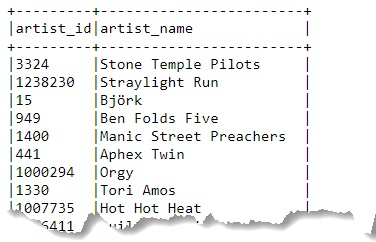

In [83]:
x[0] : x[1] for x in best_model.recommendForAllUsers(20).filter(col('user_id')==2062243).select("recommendations").collect()[0][0]

{1000873: 1.4589438438415527,
 1007735: 1.4356391429901123,
 3033: 1.4199113845825195,
 1034635: 1.3756353855133057,
 1000881: 1.34904944896698,
 4061: 1.3264453411102295,
 1252: 1.3222652673721313,
 1002835: 1.3220020532608032,
 1007498: 1.3145751953125,
 1000115: 1.3109314441680908,
 1001708: 1.302591323852539,
 1002097: 1.2970004081726074,
 1001007: 1.2966996431350708,
 949: 1.2850158214569092,
 1001483: 1.283460021018982,
 1616: 1.2808550596237183,
 1002370: 1.2774134874343872,
 1000152: 1.2692629098892212,
 1001079: 1.2681050300598145,
 1204: 1.267783522605896}

In [85]:
def get_artist_id(recommendations):
    return recommendations[0]
get_artist_id_udf = udf(get_artist_id, IntegerType())

In [101]:
# create dataframe from set
spark.createDataFrame([["woah", "mama"]] + [[x[0],x[1]] for x in best_model.recommendForAllUsers(20).filter(col('user_id')==2062243).select("recommendations").collect()[0][0]]).show()


+-------+------------------+
|     _1|                _2|
+-------+------------------+
|   woah|              mama|
|1000873|1.4589438438415527|
|1007735|1.4356391429901123|
|   3033|1.4199113845825195|
|1034635|1.3756353855133057|
|1000881|  1.34904944896698|
|   4061|1.3264453411102295|
|   1252|1.3222652673721313|
|1002835|1.3220020532608032|
|1007498|   1.3145751953125|
|1000115|1.3109314441680908|
|1001708| 1.302591323852539|
|1002097|1.2970004081726074|
|1001007|1.2966996431350708|
|    949|1.2850158214569092|
|1001483| 1.283460021018982|
|   1616|1.2808550596237183|
|1002370|1.2774134874343872|
|1000152|1.2692629098892212|
|1001079|1.2681050300598145|
+-------+------------------+
only showing top 20 rows



In [107]:
def recommendedArtists(als_model,user_id,limit):
    #get the recommendations
    selected_user = als_model.recommendForAllUsers(limit).filter(col('user_id')==user_id) 
    data = selected_user.select("recommendations").collect()[0][0]
    data = [[x[0],x[1]] for x in data]
    user_artist_rating = spark.createDataFrame(data).withColumnRenamed("_1","artist_id").withColumnRenamed("_2","rating")
    
    #join the top_artist dataframe with the artist master dataframe to include the artist_name
    top_artist = df_artist.join(user_artist_rating,df_artist.artist_id==user_artist_rating.artist_id)\
                .drop(user_artist_rating.artist_id)\
                .sort(user_artist_rating.rating.desc())
    
    return top_artist

In [108]:
#Write your code here
recommendedArtists(best_model,2062243,20).show(truncate=False)

+---------+------------------+------------------+
|artist_id|artist_name       |rating            |
+---------+------------------+------------------+
|1000873  |Our Lady Peace    |1.4589438438415527|
|1007735  |Hot Hot Heat      |1.4356391429901123|
|3033     |Matchbox Twenty   |1.4199113845825195|
|1034635  |[unknown]         |1.3756353855133057|
|1000881  |Howard Shore      |1.34904944896698  |
|4061     |Marilyn Manson    |1.3264453411102295|
|1252     |Travis            |1.3222652673721313|
|1002835  |Fastball          |1.3220020532608032|
|1007498  |10,000 Maniacs    |1.3145751953125   |
|1000115  |Papa Roach        |1.3109314441680908|
|1001708  |Thin Lizzy        |1.302591323852539 |
|1002097  |The Crystal Method|1.2970004081726074|
|1001007  |Third Eye Blind   |1.2966996431350708|
|949      |Ben Folds Five    |1.2850158214569092|
|1001483  |Powerman 5000     |1.283460021018982 |
|1616     |King Crimson      |1.2808550596237183|
|1002370  |Vertical Horizon  |1.2774134874343872|


### Congratulations on finishing this activity. See you next week.